In [1]:
# Imports
import os
import warnings
from io import StringIO
import pandas as pd
import gcsfs
from google.cloud import storage, bigquery
from datasets import Dataset, load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    ProgressCallback
)
import torch
import evaluate
import inspect
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
import matplotlib.pyplot as plt

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/mnt/disks/data/diss_bucket_key.json"
# Turn off all warnings
warnings.filterwarnings('ignore')

In [3]:
# Detect number of GPUs
gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {gpus}")
print(torch.cuda.get_device_name(0))

Number of GPUs available: 1
NVIDIA A100-SXM4-40GB


In [4]:
# === Disable Weights & Biases to avoid API prompts ===
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "dryrun"

In [29]:
# === Configuration ===
PROJECT_ID = "bamboo-mercury-462915-f0"
BQ_DATASET = "edgar_sentiment"
BQ_TABLE = "news_scores_overlap"
REGION = "europe-west2"
OUTPUT_DIR = f"gs://diss_market_data/finbert-finetune-output"
# MODEL_NAME = "yiyanghkust/finbert-tone"
NUM_LABELS = 3

# 🔁 Optional: Try stronger models if F1 plateaus
# MODEL_NAME = "ProsusAI/finbert"  # financial-news specific FinBERT
MODEL_NAME = "microsoft/deberta-v3-base"  # smaller DeBERTa finetuned on financial news

In [6]:
# Set GCP project
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

fs = gcsfs.GCSFileSystem()
with fs.open('diss_market_data/bloomberg_eval_data.csv') as f:
    df_eval = pd.read_csv(f)
df_eval.head()

,title,author,timestamp,url,content,date,filename,Label
0,Argentine Markets Freeze Prices for 60-Days Am...,B y E l i a n a R a s z e w s k i,2013-02-04T20:02:16Z,http://www.bloomberg.com/news/2013-02-04/argen...,"Argentine supermarkets, including\nlocal units...",2/4/2013,argentine-markets-freeze-prices-for-60-days-am...,Negative
1,Sharp Drops to Lowest Since 1975 on Report of ...,B y M a r i k o Y a s u,2012-07-24T08:51:10Z,http://www.bloomberg.com/news/2012-07-24/sharp...,"Sharp Corp. (6753) , Japan ’s biggest maker\n...",7/24/2012,sharp-drops-to-lowest-since-1975-on-report-of-...,Negative
2,Northwest Gasoline Drops by Most in Three Year...,B y L y n n D o a n,2012-02-28T22:42:11Z,http://www.bloomberg.com/news/2012-02-28/north...,Gasoline in the U.S. Northwest\ntumbled by the...,2/28/2012,northwest-gasoline-drops-by-most-in-three-year...,Neutral
3,NaN,Mozambique to Spend $54 Million Upgrading Hydr...,NaN,B y F r e d K a t e r e r e,--\n2011-09-07T07:11:49Z\n\n-- http://www.bloo...,9/7/2011,ozambique-to-spend-54-million-upgrading-hydro-...,Positive
4,Santander Completes $2.7 Billion Brazil Unit S...,B y P a u l T o b i n,2010-10-29T12:48:59Z,http://www.bloomberg.com/news/2010-10-29/santa...,Banco Santander SA said Qatar\nHolding LLC com...,10/29/2010,santander-completes-sale-of-2-7-billion-stake-...,Neutral


In [7]:
# === Extract data from BigQuery for training ===
bq_client = bigquery.Client()
query = f"""(SELECT article, sentiment_score, sentiment_label FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}`
        where sentiment_label IN ('Positive', 'Neutral'))
        UNION ALL
        (SELECT article, sentiment_score, sentiment_label FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}`
        where sentiment_label IN ('Negative') LIMIT 4500)
        """
df_news = bq_client.query(query).to_dataframe()
print(f"Retrieved {len(df_news)} rows from filings training table {BQ_DATASET}.{BQ_TABLE}")

Retrieved 15237 rows from filings training table edgar_sentiment.news_scores_overlap


In [8]:
# Gemini Labeled Filings in chunks
label_map = {"Negative": 2, "Neutral": 0, "Positive": 1}
df_news['label'] = df_news['sentiment_label'].map(label_map)
df_eval['label'] = df_eval['Label'].map(label_map)

In [9]:
df_eval.drop(columns=['title', 'author', 'timestamp', 'url', 'date', 'filename',
       'Label'], inplace=True)

In [10]:
# # /financial-tweets-sentiment
# ds_tweets = load_dataset("TimKoornstra/financial-tweets-sentiment")
# df_tweets = pd.DataFrame(ds_tweets['train'])

In [11]:
# financial_phrasebank
df_phrasebank = pd.read_csv("/mnt/disks/data/project_data/Financial_Phrasebank_50__Agree.csv")

In [12]:
# Changing Labels to match -> {"Negative": 2, "Neutral": 0, "Positive": 1}
label_map = {"negative": 2, "neutral": 0, "positive": 1}
df_phrasebank['sentiment'] = df_phrasebank['label']
df_phrasebank['label'] = df_phrasebank['sentiment'].map(label_map)

In [13]:
df1 = df_news[['article', 'label']].rename(columns={'article': 'text'})
# df2 = df_tweets[['tweet', 'sentiment']].rename(columns={'tweet': 'text', 'sentiment': 'label'})
df3 = df_phrasebank[['sentence', 'label']].rename(columns={'sentence': 'text'})
df_eval.rename(columns={'content': 'text'}, inplace=True)

In [14]:
df_final = pd.concat([df1])
df_eval = df_eval.dropna()
df_eval['label'] = df_eval['label'].astype(int)

In [15]:
df_final.columns, df_eval.columns

(Index(['text', 'label'], dtype='object'),
 Index(['text', 'label'], dtype='object'))

In [16]:
# # === Convert to Hugging Face Dataset ===
# train_dataset = Dataset.from_pandas(df_final[['text', 'label']])
# eval_dataset = Dataset.from_pandas(df_eval[['text', 'label']])

In [16]:
# 1. Create a single Hugging Face Dataset from df_final
ds = Dataset.from_pandas(df_final[['text', 'label']], preserve_index=False)

# 2. Split into train/test (here 80% train, 20% eval)
split = ds.train_test_split(test_size=0.2, seed=42, shuffle=True)

# 3. Assign
train_dataset_temp = split['train']
eval_dataset  = split['test']

In [17]:
df_news_split = pd.DataFrame(train_dataset_temp)

In [18]:
df_final = pd.concat([df_news_split])
df_final.columns

Index(['text', 'label'], dtype='object')

In [19]:
train_dataset = Dataset.from_pandas(df_final[['text', 'label']])

In [30]:
# === Tokenization ===
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_batch(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='longest',
        max_length=512
    )

# 🔁 Optional: Try stronger models if F1 plateaus
# MODEL_NAME = "ProsusAI/finbert"  # financial-news specific FinBERT
# MODEL_NAME = "mrm8488/deberta-v3-small-finetuned-financial-news-sentiment-analysis"  # smaller DeBERTa finetuned on financial news

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [ ]:
token_lens = [len(tokenizer.encode(text, truncation=False)) for text in df_final['text']]
plt.hist(token_lens, bins=50)
plt.xlabel("Token length")
plt.ylabel("Frequency")
plt.title("Distribution of token lengths in training data")
plt.show()

In [25]:
under_256 = sum(l <= 256 for l in token_lens)
total = len(token_lens)

percentage_under_256 = (under_256 / total) * 100
print(f"{percentage_under_256:.2f}% of texts are under 256 tokens.")

48.31% of texts are under 256 tokens.


In [31]:
tokenized_train = train_dataset.map(tokenize_batch, batched=True)
tokenized_eval = eval_dataset.map(tokenize_batch, batched=True)

Map:   0%|          | 0/12189 [00:00<?, ? examples/s]

Map:   0%|          | 0/3048 [00:00<?, ? examples/s]

In [33]:
# Check number of inputs having tokens more than 512
# num = 0
# for i in tokenized:
#   if len(i['input_ids']) > 512:
#     num += 1
# print(num)

In [34]:
# === Train/Test Split ===
# split = tokenized.train_test_split(test_size=0.1, seed=42)
# train_ds = split['train']
# eval_ds = split['test']

In [32]:
# Filter to essential columns
def keep_features(ds):
    keep = ['input_ids','attention_mask','label']
    return ds.remove_columns([c for c in ds.column_names if c not in keep])
train_ds, eval_ds = keep_features(tokenized_train), keep_features(tokenized_eval)

In [41]:
# === Model Setup ===
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

# === Configure TrainingArguments ===
base_args = {
    'output_dir': OUTPUT_DIR,
    'num_train_epochs': 5,
    'per_device_train_batch_size': 4,
    'per_device_eval_batch_size': 8,
    'eval_steps': 100,
    'save_steps': 500,
    'logging_steps': 100,
    'learning_rate': 1e-5,
    'warmup_steps': 200,
    'load_best_model_at_end': True,
    'metric_for_best_model': 'eval_loss',
    'save_total_limit': 2,
    'fp16': True,
    'dataloader_num_workers': 4,
    'report_to': 'none',
    'label_smoothing_factor': 0.1,
    'gradient_accumulation_steps': 12,  # to maintain effective batch size

}

# Dynamically add supported strategies
sig = inspect.signature(TrainingArguments)
if 'evaluation_strategy' in sig.parameters and 'save_strategy' in sig.parameters:
    base_args['evaluation_strategy'] = 'steps'
    base_args['save_strategy'] = 'steps'
else:
    base_args.pop('load_best_model_at_end', None)
    base_args.pop('metric_for_best_model', None)

# Add progress bar settings if supported
if 'disable_tqdm' in sig.parameters:
    base_args['disable_tqdm'] = False
if 'progress_bar_refresh_rate' in sig.parameters:
    base_args['progress_bar_refresh_rate'] = 20

# Initialize TrainingArguments
valid_args = {k: v for k, v in base_args.items() if k in sig.parameters}
training_args = TrainingArguments(**valid_args)

# 🔁 Optional: Try stronger models if F1 plateaus
# MODEL_NAME = "ProsusAI/finbert"  # financial-news specific FinBERT
# MODEL_NAME = "mrm8488/deberta-v3-small-finetuned-financial-news-sentiment-analysis"  # smaller DeBERTa finetuned on financial news

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
# === Metrics ===
# Pre-load accuracy and F1 metrics
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    # Compute accuracy
    acc = accuracy_metric.compute(predictions=preds, references=labels)
    # Compute weighted F1 score
    f1 = f1_metric.compute(predictions=preds, references=labels, average='weighted')
    return {
        'accuracy': acc['accuracy'],
        'f1': f1['f1']
    }

In [43]:
# === Trainer ===
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[ProgressCallback()]
)

# === Start training ===
trainer.train()

  0%|                                                                                                         …

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Step,Training Loss
100,1.087400
200,0.916100
300,0.661300
400,0.637500
500,0.607600
600,0.555200
700,0.559100
800,0.535800
900,0.509600
1000,0.516300


{'loss': 1.0874, 'grad_norm': 0.8820936679840088, 'learning_rate': 4.95e-06, 'epoch': 0.39}
{'loss': 0.9161, 'grad_norm': 4.442874908447266, 'learning_rate': 9.950000000000001e-06, 'epoch': 0.79}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'loss': 0.6613, 'grad_norm': 4.831265449523926, 'learning_rate': 9.074766355140188e-06, 'epoch': 1.18}
{'loss': 0.6375, 'grad_norm': 6.66739559173584, 'learning_rate': 8.140186915887851e-06, 'epoch': 1.57}
{'loss': 0.6076, 'grad_norm': 2.4685192108154297, 'learning_rate': 7.205607476635514e-06, 'epoch': 1.97}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'loss': 0.5552, 'grad_norm': 5.613821506500244, 'learning_rate': 6.271028037383178e-06, 'epoch': 2.36}
{'loss': 0.5591, 'grad_norm': 4.30905818939209, 'learning_rate': 5.336448598130841e-06, 'epoch': 2.76}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'loss': 0.5358, 'grad_norm': 4.38530158996582, 'learning_rate': 4.401869158878505e-06, 'epoch': 3.15}
{'loss': 0.5096, 'grad_norm': 4.743159294128418, 'learning_rate': 3.4672897196261686e-06, 'epoch': 3.54}
{'loss': 0.5163, 'grad_norm': 6.675293922424316, 'learning_rate': 2.532710280373832e-06, 'epoch': 3.94}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'loss': 0.4776, 'grad_norm': 6.407537937164307, 'learning_rate': 1.5981308411214954e-06, 'epoch': 4.33}
{'loss': 0.4806, 'grad_norm': 5.482481479644775, 'learning_rate': 6.63551401869159e-07, 'epoch': 4.72}
{'train_runtime': 1382.4599, 'train_samples_per_second': 44.084, 'train_steps_per_second': 0.919, 'train_loss': 0.6196428974782388, 'epoch': 5.0}


TrainOutput(global_step=1270, training_loss=0.6196428974782388, metrics={'train_runtime': 1382.4599, 'train_samples_per_second': 44.084, 'train_steps_per_second': 0.919, 'total_flos': 1.60357348180224e+16, 'train_loss': 0.6196428974782388, 'epoch': 5.0})

In [44]:
# === Evaluate ===
trainer.evaluate()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|                                                                                                         …

{'eval_loss': 0.6289294958114624,
 'eval_accuracy': 0.812992125984252,
 'eval_f1': 0.8131833868131825,
 'eval_runtime': 14.5734,
 'eval_samples_per_second': 209.148,
 'eval_steps_per_second': 26.143,
 'epoch': 5.0}

In [45]:
# === Save Final Model ===
OUTPUT_DIR = "./deberta_News"
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"Model and checkpoints saved to: {OUTPUT_DIR}")

Model and checkpoints saved to: ./deberta_News


In [46]:
# === Evaluate ===
results = trainer.evaluate()

# Print nicely
print("\n📊 Evaluation Metrics:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")

# Run predictions on the evaluation dataset
predictions = trainer.predict(eval_ds)
pred_labels = predictions.predictions.argmax(axis=-1)
true_labels = predictions.label_ids

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|                                                                                                         …


📊 Evaluation Metrics:
eval_loss: 0.6289
eval_accuracy: 0.8130
eval_f1: 0.8132
eval_runtime: 15.2557
eval_samples_per_second: 199.7940
eval_steps_per_second: 24.9740
epoch: 5.0000


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|                                                                                                         …

[SUCCESS] Confusion matrix with metrics saved as 'confusion_matrix_eval_news_deberta.png'

📋 Classification Report:
              precision    recall  f1-score   support

     Neutral       0.65      0.66      0.65       770
    Positive       0.84      0.84      0.84       874
    Negative       0.89      0.89      0.89      1404

    accuracy                           0.81      3048
   macro avg       0.79      0.79      0.79      3048
weighted avg       0.81      0.81      0.81      3048



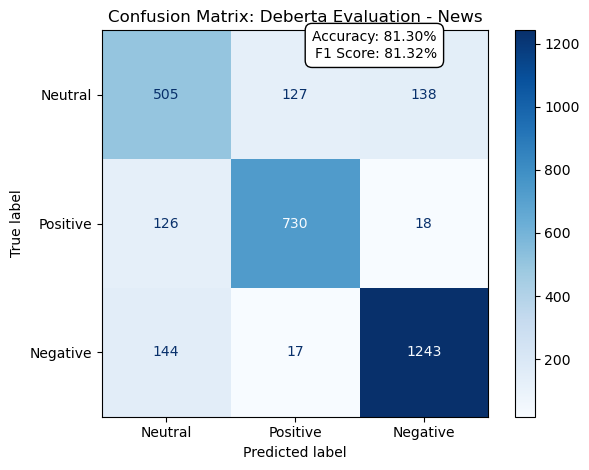

In [47]:
# === Compute metrics ===
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Neutral", "Positive", "Negative"])
disp.plot(cmap='Blues')

# === Add accuracy and F1 to the plot ===
plt.title("Confusion Matrix: Deberta Evaluation - News")
plt.text(
    2.1, -0.5,  # x, y position (tweak as needed)
    f"Accuracy: {accuracy:.2%}\nF1 Score: {f1:.2%}",
    fontsize=10,
    ha='right',
    va='top',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()
plt.savefig("confusion_matrix_eval_news_deberta.png")
print("[SUCCESS] Confusion matrix with metrics saved as 'confusion_matrix_eval_news_deberta.png'")

# === Detailed classification report ===
from sklearn.metrics import classification_report
print("\n📋 Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=["Neutral", "Positive", "Negative"]))

In [49]:
def upload_directory_to_gcs(local_dir, bucket_name, destination_dir):
    client = storage.Client()
    bucket = client.bucket(bucket_name)

    for root, _, files in os.walk(local_dir):
        for file in files:
            local_path = os.path.join(root, file)
            relative_path = os.path.relpath(local_path, local_dir)
            gcs_path = os.path.join(destination_dir, relative_path)

            blob = bucket.blob(gcs_path)
            blob.upload_from_filename(local_path)
            print(f"[UPLOAD] {local_path} → gs://{bucket_name}/{gcs_path}")

# === Upload Model Directory to GCS ===
GCS_BUCKET = "diss_market_data"
GCS_MODEL_PATH = "deberta_news" 
upload_directory_to_gcs(OUTPUT_DIR, GCS_BUCKET, GCS_MODEL_PATH)
print(f"[DONE] Model uploaded to gs://{GCS_BUCKET}/{GCS_MODEL_PATH}")

[UPLOAD] ./deberta_News/tokenizer.json → gs://diss_market_data/deberta_news/tokenizer.json
[UPLOAD] ./deberta_News/config.json → gs://diss_market_data/deberta_news/config.json
[UPLOAD] ./deberta_News/tokenizer_config.json → gs://diss_market_data/deberta_news/tokenizer_config.json
[UPLOAD] ./deberta_News/spm.model → gs://diss_market_data/deberta_news/spm.model
[UPLOAD] ./deberta_News/special_tokens_map.json → gs://diss_market_data/deberta_news/special_tokens_map.json
[UPLOAD] ./deberta_News/added_tokens.json → gs://diss_market_data/deberta_news/added_tokens.json
[UPLOAD] ./deberta_News/training_args.bin → gs://diss_market_data/deberta_news/training_args.bin
[UPLOAD] ./deberta_News/model.safetensors → gs://diss_market_data/deberta_news/model.safetensors
[DONE] Model uploaded to gs://diss_market_data/deberta_news
